# Business understanding
Goal is to construct a model implementing logistic regression in order to predict whether a property's house price of unit area (10000 New Taiwan Dollar/Pin, 1 Ping = 3.3 m^2) is above the mean price of the dataset.

Fetch the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo 

real_estate_valuation = fetch_ucirepo(id=477) 

X = real_estate_valuation.data.features.copy() 
y = real_estate_valuation.data.targets 


avg_price = y['Y house price of unit area'].mean()
y.loc[:, 'Y house price of unit area'] = np.where(y['Y house price of unit area'] > avg_price, 1, 0)

## Data Understanding

### Dataset Overview
The dataset used in this project comes from the UCI Machine Learning Repository, containing real estate valuation data from New Taipei City, Taiwan. It includes six features related to housing and one target variable (house price per unit area). 

### Data Sources
- Dataset Name: Real Estate Valuation  
- Region Covered: New Taipei City, Taiwan  
- Number of Observations: 414  
- Number of Features: 6  
- Target Variable: `y` (house price per unit area)  

### Feature Descriptions
| Feature | Description | Data Type |
|---|---|---|
| `X1 transaction date` | The year and month the house was sold (continuous) | Numeric |
| `X2 house age` | The age of the house in years (continuous) | Numeric |
| `X3 distance to the nearest MRT station` | Distance to the closest metro station in meters (continuous) | Numeric |
| `X4 number of convenience stores` | Number of nearby convenience stores (discrete) | Integer |
| `X5 latitude` | Geographic latitude of the house (continuous) | Numeric |
| `X6 longitude` | Geographic longitude of the house (continuous) | Numeric |

There are no missing values and there are no egregious outliers.

## Data Preparation

### Preprocessing Steps
Since the dataset does not contain missing values or obvious inconsistencies, minimal preprocessing was required. However, two key steps were performed to ensure the model receives properly formatted input data.

Standardization 
   - Features were standardized to have zero mean and unit variance using `StandardScaler` from `sklearn.preprocessing`.
   - This transformation helps improve model performance by ensuring all features contribute equally, especially when they are on different scales.

Converting all features to float

In [2]:
for col in X.columns.values:
    if X[col].dtype != 'float64':
        X[col] = X[col].astype(dtype='float64')

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

## Modeling
The logistic regression model is trained with the Limited-memory BFGS (lbfgs) as the solver algorithm which uses the L2 regularization to prevent overfitting.\
In logistic regression, the coefficients are not directly interpretable as feature importance, because the coefficients are transformed by the logistic function.\
The model is tested with the cross_val_predict() function that generates cross-validated estimates for each input data point. And the accuracy of the model's predictions are ~83%.

In [3]:
reg = LogisticRegression(solver='lbfgs')
reg.fit(X_scaled, y.values.ravel()) 
print(reg.coef_)

[[ 0.30499188 -0.6521808  -2.3880496   0.62862116  0.96306763  0.07518563]]


In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(estimator=reg, X=X, y=y.values.ravel(), cv=10)

accuracy = accuracy_score(y, y_pred)

print("Accuracy: %0.2f" % accuracy)

Accuracy: 0.83


## Evaluation
We've evaluated the model using a confusion matrix that shows that the model incorrectly predicted the unit price to be above the mean in 45 cases and below the mean in 25 cases.\
The permutation importance illustrates the importance of a feature when predicting an outcome. In this case it seems that the distance to the nearest MRT station is the biggest factor while the other features' importances are near or at zero.

Constructing the confusion matrix

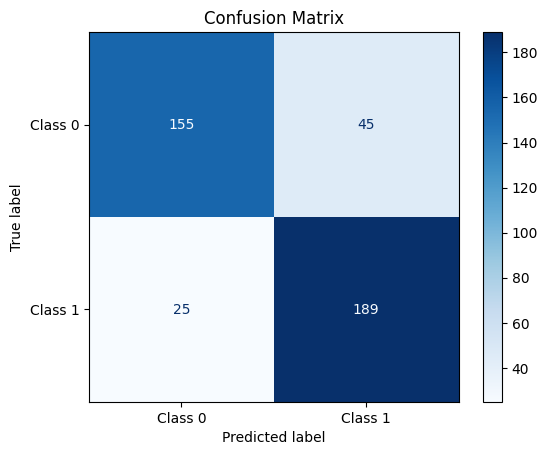

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, y_pred)

cmd = ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1'])

fig, ax = plt.subplots()
cmd.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_title('Confusion Matrix')

plt.show()

In [6]:
# feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(reg, X.values, y, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Deployment
The practical use of this model is limited. Predicting whether a house's price of unit area is above or below the mean is more intuitively done by knowing the actual price and size of the house.\
The model could be used to predict the desirability of a house to more accurately appraise it's value compared to other similar sized houses.\
A practical application could utilize an interactive prediction like the one shown below to predict the probability of a house being above the mean of the dataset.

In [ ]:
# interactive prediction
features=['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
Xi = pd.DataFrame(columns=features)

# read input data
for f in features:
    val = input(f"Enter value for feature: {f}")
    Xi[f] = [float(val)]

# get probability estimate
Xi = pd.DataFrame(scaler.transform(Xi.values), columns=Xi.columns)
p = reg.predict_proba(Xi.values)[:,1]

# output
print("Probability : %0.2f" % p[0])